In [21]:
import os
import sys
import json
sys.path.append('..')
sys.path.append('../src')

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import decode_image
from torchvision.models.feature_extraction import create_feature_extractor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.image_process import show_image, load_image_and_metadata

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load a Pre-trained Model

In [2]:
# cache weights to a project folder
os.environ['TORCH_HOME'] = '../cache'

In [3]:
# Init model with pre-trained weights
pre_trained_weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=pre_trained_weights)

# Set model to eval mode
model.eval()

print("ResNet50 Loaded.")

ResNet50 Loaded.


In [4]:
# Get data transforms
process = pre_trained_weights.transforms()
process

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# 2. Visualize Output from each Block

In [5]:
return_node = {
    "layer1": "block1",
    "layer2": "block2",
    "layer3": "block3",
    "layer4": "block4",
}

In [6]:
feat_extractor = create_feature_extractor(model, return_nodes=return_node)

In [8]:
# Import an image
filename = '../data/validation/image/000001.jpg'
img = decode_image(filename)
img.size()

torch.Size([3, 624, 468])

In [10]:
model_input = process(img)
model_input = model_input.unsqueeze(0)
print(f"Processed image size: {model_input.size()}")
with torch.no_grad():
    features = feat_extractor(model_input)

Processed image size: torch.Size([1, 3, 224, 224])


In [11]:
feat_by_block = features['block1'].squeeze(0)
feat_by_block.size()

torch.Size([256, 56, 56])

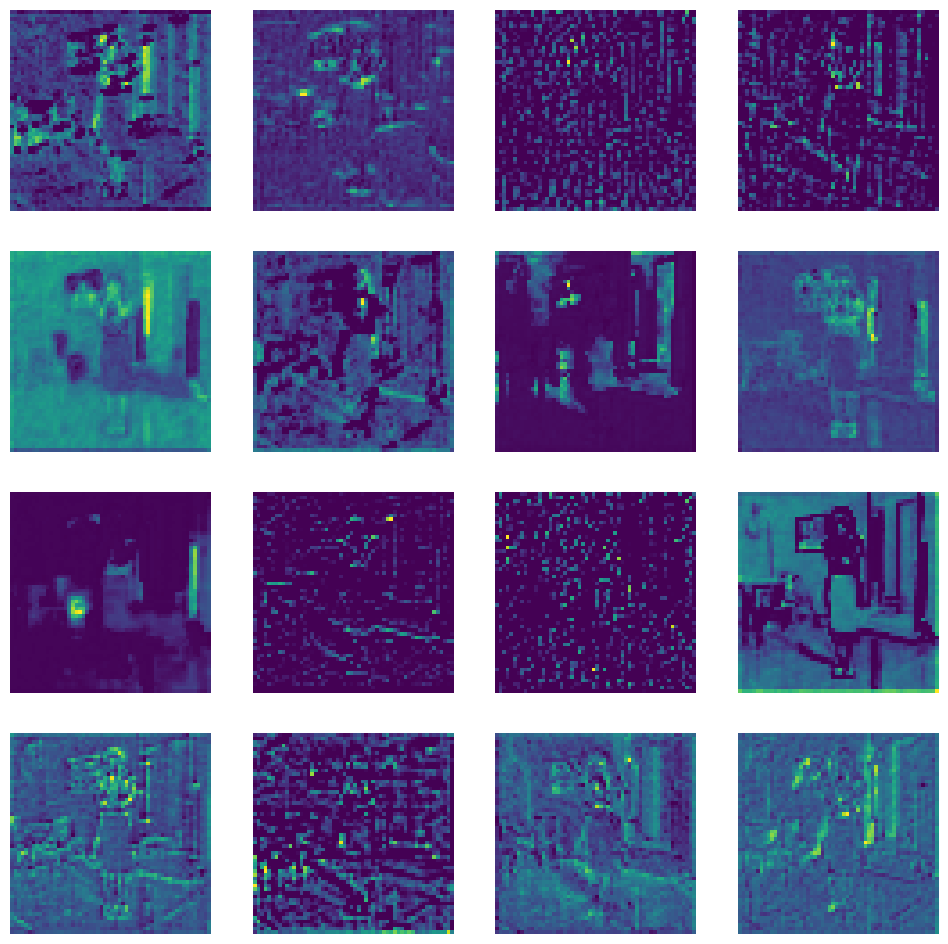

In [12]:
fig ,axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(feat_by_block[i].cpu(), cmap='viridis')
    ax.axis("off")

plt.show()

# 3. Explore Dataset

## 3.1 Extract Meta Data

In [51]:
# get pairs of (img_id, pair_id, image_source)
id_pairs_list = []
for file in os.listdir('../data/validation/annos'):
    filename = f'../data/validation/annos/{file}'
    with open(filename, 'r') as f:
        img_metadata = json.load(f)
        pair_id = img_metadata['pair_id']
        source = img_metadata['source']

    id_pairs_list.append([file, pair_id, source])

In [52]:
df_id_pairs = pd.DataFrame(
    id_pairs_list, 
    columns=['filename', 'pair_id', 'img_source'], 
        )
df_id_pairs.head()

,filename,pair_id,img_source
0,000001.json,1,user
1,000002.json,1,user
2,000003.json,3,user
3,000004.json,3,user
4,000005.json,4,user


In [53]:
# Save metadata to csv
df_id_pairs.to_csv('../data/validation/file_pair_id.csv', index=False)

## 3.2 Visualize Samples with Metadata

In [13]:
# Load image metadata
df_id_pairs = pd.read_csv('../data/validation/file_pair_id.csv')
df_id_pairs.head(2)

,filename,pair_id,img_source
0,000001.json,1,user
1,000002.json,1,user


In [16]:
img_dir = '../data/validation/image'
metadata_dir = '../data/validation/annos'

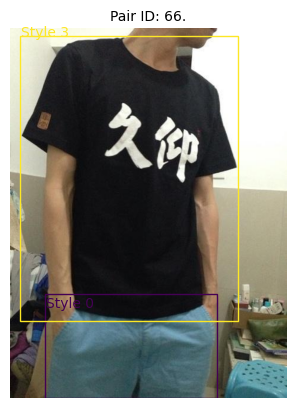

In [18]:
# Example of User iamge
img, bboxes, pair_id = load_image_and_metadata('000343', image_dir=img_dir, metadata_dir=metadata_dir)
show_image(img, bboxes=bboxes, pair_id=pair_id)

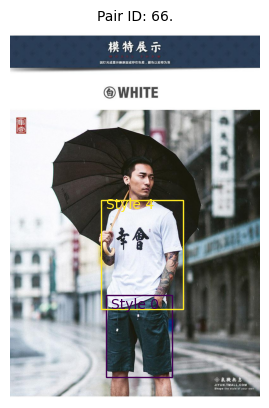

In [19]:
# Example of shop iamge
img, bboxes, pair_id = load_image_and_metadata('011436', image_dir=img_dir, metadata_dir=metadata_dir)
show_image(img, bboxes=bboxes, pair_id=pair_id)

There are several non-zero styles with the same pair_id. This means these clothes are in the same shop with different logo or colors.

In [20]:
# Count of shop and user images
df_id_pairs.groupby('img_source').count()

,filename,pair_id
img_source,,
shop,21309,21309
user,10844,10844
